## Importing required libraries

In [49]:
import sys
sys.path.append('/home/aistudio/external-libraries')

import jax
import jax.numpy as jnp
import jax.random as random

import time
import math
import numpy as np
import pandas as pd

import optax
import jaxopt
import matplotlib.pyplot as plt
from matplotlib import font_manager
import matplotlib.gridspec as gridspec
from typing import Tuple
import spectral_method_2 as sm

import scipy.io
from scipy.stats import qmc
from scipy.special import factorial
jax.config.update("jax_enable_x64", True)

font_path = '/home/aistudio/Times_New_Roman.ttf'
prop = font_manager.FontProperties(fname=font_path)

## Config for solving DDE

In [50]:
# config = {
#     "real_lag": [0.2, 0.3, 0.4, 0.5],
#     "tmin": 0.,
#     "tmax": 1.,
#     "initial_key": 0,
#     "conds": [0., 1., 1., 1.],
#     "netLayers": [1, 20, 40, 20, 1],
#     "record_info": False,
#     "gap": 2000,
#     "N_f": 1000,
#     "loss_threshold": 1e-10,
#     "step_epochs": [2000, 10000],
#     "initial_lr" : 1e-3,
#     "cosine_decay_steps": 1000,
#     "cosine_alpha": 0.01,
#     "DDE23_data_root_path": "/home/aistudio/DDE_2rd_revision/data/ex4.3.1",
#     "result_save_path": "/home/aistudio/DDE_2rd_revision/result/ex4.3.1"
# }

In [ ]:
# Retrieve the variable 'config' from IPython's storage space
%store -r config

## Defining the System of Delay Differential Equation

Consider the system of delay differential equations with quadruple delays on the solution interval $[0,100]$:

\begin{equation}
    \begin{cases}
    \begin{aligned}
    y_1'(t) ={} & y_1(t-0.2)\\
    y_2'(t) ={} & y_1(t-0.3) \cdot y_2(t-0.4)\\
    y_3'(t) ={} & y_2(t-0.5)
    \end{aligned}
    \end{cases}.
\end{equation}


The initial conditions are given by

\begin{equation}
    y_j(t) = 1,~\mathrm{for}\; t \neq 0,\; j=1:3.
\end{equation}

In [51]:
def DDEs(t, u, lag):
    rhs = [
        jnp.where(t > lag[0], u(t - lag[0])[0], 1),
        jnp.where(t > lag[1], u(t - lag[1])[0], 1) * jnp.where(t > lag[2], u(t - lag[2])[1], 1),
        jnp.where(t > lag[3], u(t - lag[3])[1], 1)
    ]
    tem_list = []

    for i in range(3):
        u_t = lambda t: jax.grad(lambda t: jnp.sum(u(t)[i]))(t)
        tem_i = u_t(t) - rhs[i]
        tem_list.append(tem_i.reshape(-1, 1))

    tem = jnp.hstack(tem_list)
    
    return tem

## Construct the DNNs and initialize parameters

In [52]:
# Define the DNNs model
def DNNs(params, x):
    for w, b in params[0:-1]:
        x = jnp.dot(x, w) + b
        x = jnp.tanh(x)

    w, b = params[-1]
    x = jnp.dot(x, w) + b
    return x

# Xavier initialization for the layer parameters
def random_layer_params_xavier(m, n, key):
    xavier_stddev = jnp.sqrt(2.0 / (m + n))

    w_key, b_key = jax.random.split(key)

    weights = xavier_stddev * jax.random.truncated_normal(
        w_key, lower=-2.0, upper=2.0, shape=(m, n)
    )
    biases = jnp.zeros((n,))

    return weights, biases

# Initialize parameters for all layers in a fully-connected neural network with the specified sizes
def init_network_params(sizes, key):
    keys = jax.random.split(key, len(sizes))
    return [random_layer_params_xavier(m, n, k) for m, n, k in zip(sizes[:-1], sizes[1:], keys)]

## Define the loss function

In [53]:
@jax.jit
def loss_fun1(params, lag, inPoints, conds):
    t_c = inPoints[:, [0]]

    ufunc1 = lambda t: DNNs(params[0], t)
    ufunc2 = lambda t: DNNs(params[1], t)
    ufunc3 = lambda t: DNNs(params[2], t)

    def u(t):
        return [ufunc1(t), ufunc2(t), ufunc3(t)]

    # Differential equation residual losses
    res = DDEs(t_c, u, lag)
    loss_f1 = jnp.mean((res[:, 0])**2)
    loss_f2 = jnp.mean((res[:, 1])**2)
    loss_f3 = jnp.mean((res[:, 2])**2)

    # Initial condition losses
    t_0, u1_0, u2_0, u3_0 = conds[:, [0]], conds[:, [1]], conds[:, [2]], conds[:, [3]]
    loss_i1 = jnp.mean((ufunc1(t_0) - u1_0)**2)
    loss_i2 = jnp.mean((ufunc2(t_0) - u2_0)**2)
    loss_i3 = jnp.mean((ufunc3(t_0) - u3_0)**2)

    # Gather all loss terms
    all_losses = jnp.array([loss_f1, loss_f2, loss_f3, loss_i1, loss_i2, loss_i3])
    total_loss = jnp.sum(all_losses)

    # Dynamic weights
    weights = all_losses / total_loss

    # Weighted total loss
    loss_weighted = jnp.sum(all_losses * weights)

    return loss_weighted, all_losses


@jax.jit
def loss_fun2(params, lag, inPoints, conds, initial_weights):
    t_c = inPoints[:, [0]]

    ufunc1 = lambda t: DNNs(params[0], t)
    ufunc2 = lambda t: DNNs(params[1], t)
    ufunc3 = lambda t: DNNs(params[2], t)

    def u(t):
        return [ufunc1(t), ufunc2(t), ufunc3(t)]

    # Differential equation residual losses
    res = DDEs(t_c, u, lag)
    loss_f1 = jnp.mean((res[:, 0])**2)
    loss_f2 = jnp.mean((res[:, 1])**2)
    loss_f3 = jnp.mean((res[:, 2])**2)

    # Initial condition losses
    t_0, u1_0, u2_0, u3_0 = conds[:, [0]], conds[:, [1]], conds[:, [2]], conds[:, [3]]
    loss_i1 = jnp.mean((ufunc1(t_0) - u1_0)**2)
    loss_i2 = jnp.mean((ufunc2(t_0) - u2_0)**2)
    loss_i3 = jnp.mean((ufunc3(t_0) - u3_0)**2)

    # Gather all loss terms
    all_losses = jnp.array([loss_f1, loss_f2, loss_f3, loss_i1, loss_i2, loss_i3])
    total_loss = jnp.sum(all_losses)

    # Weighted total loss
    loss_weighted = jnp.sum(all_losses * initial_weights)

    return loss_weighted, all_losses

## Two-step neural network training

In [54]:
# First Step：Adam Optimizer
def train_adam(params, lag, inPoints, conds, record_info, num_epochs, start_epoch=0, log_interval=100, print_interval=1000):
    phase_epochs = []
    phase_losses = []
    phase_loss_terms = []

    scheduler = optax.cosine_decay_schedule(
        init_value=config['initial_lr'],
        decay_steps=config['cosine_decay_steps'],
        alpha=config['cosine_alpha']
    )
    optimizer = optax.adam(learning_rate=scheduler)
    opt_state = optimizer.init(params)

    @jax.jit
    def update_adam(params, lag, inPoints, conds, opt_state):
        (loss, all_losses), grads = jax.value_and_grad(loss_fun1, has_aux=True)(
            params, lag, inPoints, conds
        )
        updates, opt_state = optimizer.update(grads, opt_state, params)
        params = optax.apply_updates(params, updates)
        return params, opt_state, (loss, all_losses)

    if record_info:
        for epoch in range(num_epochs):
            params, opt_state, (loss, all_losses) = update_adam(
                params, lag, inPoints, conds, opt_state
            )
            current_epoch = start_epoch + epoch

            if record_info and current_epoch % log_interval == 0:
                phase_epochs.append(current_epoch)
                phase_losses.append(loss)
                phase_loss_terms.append(all_losses)

            if record_info and current_epoch % print_interval == 0:
                print(f"Epoch {current_epoch}, Total Loss: {loss:.3e}")
        
        return params, phase_epochs, phase_losses, phase_losses, all_losses
    else:
        now_epoch = 0
        while now_epoch < num_epochs:
            params, opt_state, (loss, all_losses) = update_adam(
                params, lag, inPoints, conds, opt_state
            )
            now_epoch += 1
        return params, None, None, None, all_losses


# Second Step：L-BFGS Optimizer
def train_lbfgs(params, lag, inPoints, conds, initial_weights,
                record_info, num_epochs=10000, gap=100, start_epoch=0):

    phase_epochs = []
    phase_losses = []
    phase_loss_terms = []

    current_params = params

    if record_info:
        solver = jaxopt.BFGS(
            fun=loss_fun2,
            tol=1e-16,
            maxiter=gap,
            has_aux=True,
            verbose=False
        )

        for epoch in range(start_epoch, start_epoch + num_epochs + 1, gap):
            sol = solver.run(current_params, lag, inPoints, conds, initial_weights)
            current_params = sol.params
            loss, all_losses = sol.state.value, sol.state.aux

            phase_losses.append(loss)
            phase_loss_terms.append(all_losses)
            phase_epochs.append(epoch + gap)

            print(f"Epoch {epoch+gap}, Total Loss: {loss:.3e}")

        return current_params, phase_epochs, phase_losses, phase_loss_terms, all_losses

    else:
        solver = jaxopt.BFGS(
            fun=loss_fun2,
            tol=1e-16,
            maxiter=num_epochs,
            has_aux=True,
            verbose=False
        )
        sol = solver.run(current_params, lag, inPoints, conds, initial_weights)
        current_params = sol.params
        return current_params, None, None, None, sol.state.aux

def get_fixed_weights(loss_jnp):
    losses = jax.lax.stop_gradient(loss_jnp)
    return losses / jnp.sum(losses)

## Boundary Condition Initialization and Random Sampling Strategy for Solving DDE

In [55]:
lag = config["real_lag"]

# conds represents the initial condition y(0) = 1
conds = jnp.array(config['conds']).reshape(1,-1)

# Initial key for random number generator
ik = config['initial_key']

# Number of internal random points
N_f = config['N_f']

# Range for sampling points
tmin, tmax = config['tmin'], config['tmax']

# Generate random points within the specified range
jaxKey = jax.random.PRNGKey(ik)

sampler = qmc.LatinHypercube(d=1)

sample = sampler.random(n=N_f)
Inn_T = qmc.scale(sample, tmin, tmax)
inPoints = jnp.array(Inn_T)

# Network architecture
netLayers = config['netLayers']

# Initialize network parameters
params = [init_network_params(netLayers, jaxKey)]*3

## Training

In [ ]:
epoch_history = []
loss_history = []
loss_items_hostory = []

adam_epochs = config["step_epochs"][0]
lbfgs_epochs = config["step_epochs"][1]
stage1_epochs = adam_epochs + lbfgs_epochs

record_info = config['record_info']
gap = config['gap']

start_time_nn = time.time()

# First stage: Adam
params, hist1_epoch, hist1_loss, hist1_loss_items, loss_components = train_adam(params, lag, inPoints, conds, record_info, adam_epochs, start_epoch=0, log_interval=100, print_interval=1000)

initial_weights = get_fixed_weights(loss_components)

# Second stage: L-BFGS
params, hist2_epoch, hist2_loss, hist2_loss_items, _ = train_lbfgs(params, lag, inPoints, conds, initial_weights, record_info, num_epochs=lbfgs_epochs, gap=gap, start_epoch=adam_epochs)

end_time_nn = time.time()
time_nn = end_time_nn - start_time_nn

if record_info:
    epoch_history.extend(hist1_epoch + hist2_epoch)
    loss_history.extend(hist1_loss + hist2_loss)
    loss_items_hostory.extend(hist1_loss_items + hist2_loss_items)
    loss_items_history_array = jnp.stack(loss_items_hostory)

## Result visualization

In [57]:
# Convert the list of real_lag values to a string with values separated by underscores
lag_string = '_'.join(str(lag) for lag in config['real_lag'])

result_save_root_path = os.path.join(config['result_save_path'],f"tau_{lag_string}")
os.makedirs(result_save_root_path, exist_ok=True)

### DDE23 solution

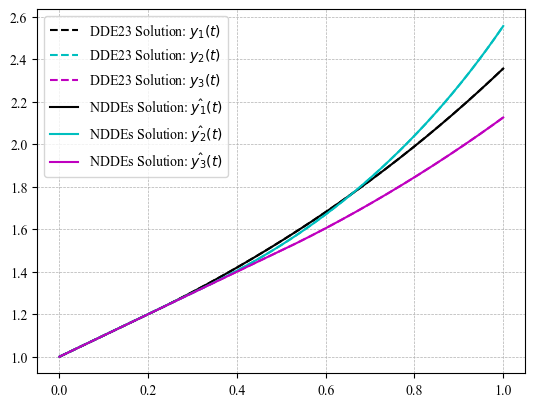

In [58]:
# MATLAB solution
dde_solve_path = os.path.join(config['DDE23_data_root_path'], f"DDE23_ex4.3.1_tau_{lag_string}.csv")
dde_sol = pd.read_csv(dde_solve_path).to_numpy().reshape(-1, 4)

# Extract time points and real values from the data for three different series
t_points = dde_sol[:, 0]
y1_real = dde_sol[:, 1]
y2_real = dde_sol[:, 2]
y3_real = dde_sol[:, 3]

# Generate a set of 10,000 evenly spaced time points between tmin and tmax
T = np.array(dde_sol[:, 0]).reshape(-1,1)

# Evaluate the neural network for three sets of parameters to get predictions for each set
nn_sol1 = DNNs(params[0], T)
nn_sol2 = DNNs(params[1], T)
nn_sol3 = DNNs(params[2], T)

# Set the figure size to 16 cm wide by 12 cm tall (4:3 aspect ratio)
plt.figure(figsize=(16 / 2.54, 12 / 2.54))

# Plot real and predicted values for three series using different styles and colors
plt.plot(t_points, y1_real, '--k', label='DDE23 Solution: $y_1(t)$')
plt.plot(t_points, y2_real, '--c', label='DDE23 Solution: $y_2(t)$')
plt.plot(t_points, y3_real, '--m', label='DDE23 Solution: $y_3(t)$')

plt.plot(T, nn_sol1, 'k', label='NDDEs Solution: $\hat{y_1}(t)$')
plt.plot(T, nn_sol2, 'c', label='NDDEs Solution: $\hat{y_2}(t)$')
plt.plot(T, nn_sol3, 'm', label='NDDEs Solution: $\hat{y_3}(t)$')

# Add a legend with font properties
plt.legend(prop=prop)

# Set labels for the x and y axes with font properties
# plt.xlabel('$t$', fontproperties=prop)
# plt.ylabel('$y(t)$', fontproperties=prop)

# Customize the appearance of the axis tick labels using font properties
ax = plt.gca()
for label in ax.get_xticklabels() + ax.get_yticklabels():
    label.set_fontproperties(prop)

# Enable grid lines for major axes with specified style and line width
plt.grid(True, which='major', axis='both', linestyle='--', linewidth=0.5)

# Optionally save the figure with high resolution
save_path = os.path.join(result_save_root_path, f"Sol_ex4.3.1_ex4.3.1_N_f_{config['N_f']}_tau_{lag_string}.png")
plt.savefig(save_path, dpi=600, bbox_inches='tight')

# Display the plot
# plt.show()

### y1

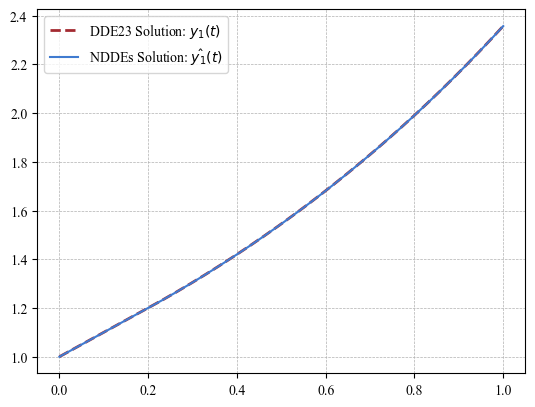

In [59]:
# Set the figure size to 16 cm wide by 12 cm tall (4:3 aspect ratio)
plt.figure(figsize=(16 / 2.54, 12 / 2.54))

# Define a list of colors for different plots
colorList = ['#A32A31', '#407BD0']

# Plot real values obtained from MATLAB's DDE23 solver
plt.plot(t_points, y1_real, '--', label='DDE23 Solution: $y_1(t)$', color=colorList[0], linewidth=2)
# Plot predicted values from the neural delay differential equation solver (NDDEs)
plt.plot(T, nn_sol1, label='NDDEs Solution: $\hat{y_1}(t)$', color=colorList[1])

# # Set labels for the x and y axes with custom font properties
# plt.xlabel('$t$', fontproperties=prop)
# plt.ylabel('$y_1$', fontproperties=prop)

# Enable grid lines for major axes with specified style and line width
plt.grid(True, which='major', axis='both', linestyle='--', linewidth=0.5)

# Add a legend with custom font properties
plt.legend(prop=prop)

# Get the current axes to adjust tick labels
ax = plt.gca()
# Customize the appearance of the axis tick labels using font properties
for label in ax.get_xticklabels() + ax.get_yticklabels():
    label.set_fontproperties(prop)

# Optionally save the figure with high resolution
save_path = os.path.join(result_save_root_path, f"Y_1_ex4.3.1_N_f_{config['N_f']}_tau_{lag_string}.png")
plt.savefig(save_path, dpi=600, bbox_inches='tight')

# Display the plot
# plt.show()

### y2

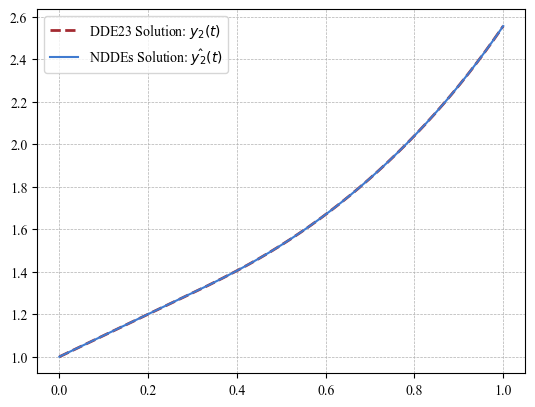

In [60]:
# Set the figure size to 16 cm wide by 12 cm tall (4:3 aspect ratio)
plt.figure(figsize=(16 / 2.54, 12 / 2.54))

# Define a list of colors for different plots
colorList = ['#A32A31', '#407BD0']

# Plot real values obtained from MATLAB's DDE23 solver
plt.plot(t_points, y2_real, '--', label='DDE23 Solution: $y_2(t)$', color=colorList[0], linewidth=2)
# Plot predicted values from the neural delay differential equation solver (NDDEs)
plt.plot(T, nn_sol2, label='NDDEs Solution: $\hat{y_2}(t)$', color=colorList[1])

# Set labels for the x and y axes with custom font properties
# plt.xlabel('$t$', fontproperties=prop)
# plt.ylabel('$y_2$', fontproperties=prop)

# Enable grid lines for major axes with specified style and line width
plt.grid(True, which='major', axis='both', linestyle='--', linewidth=0.5)

# Add a legend with custom font properties
plt.legend(prop=prop)

# Get the current axes to adjust tick labels
ax = plt.gca()
# Customize the appearance of the axis tick labels using font properties
for label in ax.get_xticklabels() + ax.get_yticklabels():
    label.set_fontproperties(prop)

# Optionally save the figure with high resolution
save_path = os.path.join(result_save_root_path, f"Y_2_ex4.3.1_N_f_{config['N_f']}_tau_{lag_string}.png")
plt.savefig(save_path, dpi=600, bbox_inches='tight')

# Display the plot
# plt.show()

### y3

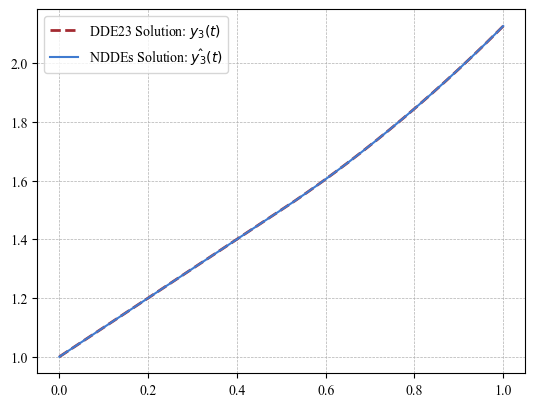

In [61]:
# Set the figure size to 16 cm wide by 12 cm tall (4:3 aspect ratio)
plt.figure(figsize=(16 / 2.54, 12 / 2.54))

# Define a list of colors for different plots
colorList = ['#A32A31', '#407BD0']

# Plot real values obtained from MATLAB's DDE23 solver
plt.plot(t_points, y3_real, '--', label='DDE23 Solution: $y_3(t)$', color=colorList[0], linewidth=2)
# Plot predicted values from the neural delay differential equation solver (NDDEs)
plt.plot(T, nn_sol3, label='NDDEs Solution: $\hat{y_3}(t)$', color=colorList[1])

# Set labels for the x and y axes with custom font properties
# plt.xlabel('$t$', fontproperties=prop)
# plt.ylabel('$y_3$', fontproperties=prop)

# Enable grid lines for major axes with specified style and line width
plt.grid(True, which='major', axis='both', linestyle='--', linewidth=0.5)

# Add a legend with custom font properties
plt.legend(prop=prop)

# Get the current axes to adjust tick labels
ax = plt.gca()
# Customize the appearance of the axis tick labels using font properties
for label in ax.get_xticklabels() + ax.get_yticklabels():
    label.set_fontproperties(prop)

# Optionally save the figure with high resolution
save_path = os.path.join(result_save_root_path, f"Y_3_ex3.1_N_f_{config['N_f']}_tau_{lag_string}.png")
plt.savefig(save_path, dpi=600, bbox_inches='tight')

# Display the plot
# plt.show()

### Error

In [62]:
nn_sol1 = np.array(nn_sol1)
nn_sol2 = np.array(nn_sol2)
nn_sol3 = np.array(nn_sol3)

y1_real = y1_real.reshape(-1,1)
y2_real = y2_real.reshape(-1,1)
y3_real = y3_real.reshape(-1,1)

# Absolute and relative errors between nn_solutions and dde_solutions
abs_error_nn_dde1 = np.abs(nn_sol1 - y1_real)
rel_error_nn_dde1 = np.linalg.norm(nn_sol1 - y1_real, ord=2) / np.linalg.norm(y1_real, ord=2)
mae_nn_dde1 = np.mean(abs_error_nn_dde1)  # Calculate Mean Absolute Error (MAE)

abs_error_nn_dde2 = np.abs(nn_sol2 - y2_real)
rel_error_nn_dde2 = np.linalg.norm(nn_sol2 - y2_real, ord=2) / np.linalg.norm(y2_real, ord=2)
mae_nn_dde2 = np.mean(abs_error_nn_dde2)  # Calculate Mean Absolute Error (MAE)

abs_error_nn_dde3 = np.abs(nn_sol3 - y3_real)
rel_error_nn_dde3 = np.linalg.norm(nn_sol3 - y3_real, ord=2) / np.linalg.norm(y3_real, ord=2)
mae_nn_dde3 = np.mean(abs_error_nn_dde3)  # Calculate Mean Absolute Error (MAE)

# Printing results
print("Relative error between nn_sol1 and y1_real:", rel_error_nn_dde1)
print("Mean Absolute Error (MAE) between nn_sol1 and y1_real:", mae_nn_dde1)
print("Relative error between nn_sol2 and y2_real:", rel_error_nn_dde2)
print("Mean Absolute Error (MAE) between nn_sol2 and y2_real:", mae_nn_dde2)
print("Relative error between nn_sol3 and y3_real:", rel_error_nn_dde3)
print("Mean Absolute Error (MAE) between nn_sol3 and y3_real:", mae_nn_dde3)

# Save results to a txt file
save_path = os.path.join(result_save_root_path, f"Results_ex4.3.1_N_f_{config['N_f']}_tau_{lag_string}.txt")
results_path = os.path.join(os.getcwd(), save_path)
with open(results_path, "w") as file:
    file.write("Relative and Mean Absolute Errors\n")
    file.write("=================================\n")
    file.write(f"Relative error between nn_sol1 and y1_real: {rel_error_nn_dde1}\n")
    file.write(f"Mean Absolute Error (MAE) between nn_sol1 and y1_real: {mae_nn_dde1}\n")
    file.write(f"Relative error between nn_sol2 and y2_real: {rel_error_nn_dde2}\n")
    file.write(f"Mean Absolute Error (MAE) between nn_sol2 and y2_real: {mae_nn_dde2}\n")
    file.write(f"Relative error between nn_sol3 and y3_real: {rel_error_nn_dde3}\n")
    file.write(f"Mean Absolute Error (MAE) between nn_sol3 and y3_real: {mae_nn_dde3}\n")

print(f"Results have been saved to {results_path}")

Relative error between nn_sol1 and y1_real: 0.00010191039749446732
Mean Absolute Error (MAE) between nn_sol1 and y1_real: 0.000162729960706392
Relative error between nn_sol2 and y2_real: 9.82942713845538e-05
Mean Absolute Error (MAE) between nn_sol2 and y2_real: 0.00015858200608625034
Relative error between nn_sol3 and y3_real: 2.0510851691420252e-05
Mean Absolute Error (MAE) between nn_sol3 and y3_real: 1.9997143645472536e-05
Results have been saved to /home/aistudio/DDE_2rd_revision/result/ex4.3.1/tau_0.2_0.3_0.4_0.5/Results_ex4.3.1_N_f_1000_tau_0.2_0.3_0.4_0.5.txt
